In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_squared_error

In [3]:
df = pd.read_csv('../data/OnlineNewsPopularity.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39644 entries, 0 to 39643
Data columns (total 61 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             39644 non-null  object 
 1    timedelta                      39644 non-null  float64
 2    n_tokens_title                 39644 non-null  float64
 3    n_tokens_content               39644 non-null  float64
 4    n_unique_tokens                39644 non-null  float64
 5    n_non_stop_words               39644 non-null  float64
 6    n_non_stop_unique_tokens       39644 non-null  float64
 7    num_hrefs                      39644 non-null  float64
 8    num_self_hrefs                 39644 non-null  float64
 9    num_imgs                       39644 non-null  float64
 10   num_videos                     39644 non-null  float64
 11   average_token_length           39644 non-null  float64
 12   num_keywords                   

In [50]:
df.drop(['url',' timedelta'], axis=1, inplace=True)

In [114]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
n_tokens_title,39644.0,10.398749,2.114037,2.00000,9.000000,10.000000,12.000000,23.000000
n_tokens_content,39644.0,546.514731,471.107508,0.00000,246.000000,409.000000,716.000000,8474.000000
n_unique_tokens,39644.0,0.548216,3.520708,0.00000,0.470870,0.539226,0.608696,701.000000
n_non_stop_words,39644.0,0.996469,5.231231,0.00000,1.000000,1.000000,1.000000,1042.000000
n_non_stop_unique_tokens,39644.0,0.689175,3.264816,0.00000,0.625739,0.690476,0.754630,650.000000
num_hrefs,39644.0,10.883690,11.332017,0.00000,4.000000,8.000000,14.000000,304.000000
num_self_hrefs,39644.0,3.293638,3.855141,0.00000,1.000000,3.000000,4.000000,116.000000
num_imgs,39644.0,4.544143,8.309434,0.00000,1.000000,1.000000,4.000000,128.000000
num_videos,39644.0,1.249874,4.107855,0.00000,0.000000,0.000000,1.000000,91.000000
average_token_length,39644.0,4.548239,0.844406,0.00000,4.478404,4.664082,4.854839,8.041534


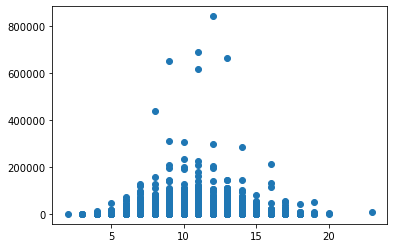

In [10]:
fig, ax = plt.subplots()
ax.scatter(df[' n_tokens_title'], df[' shares'])


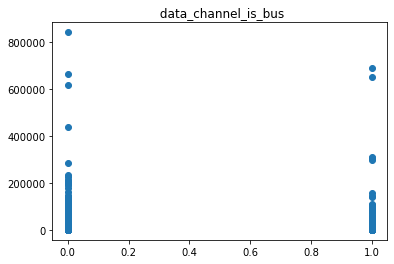

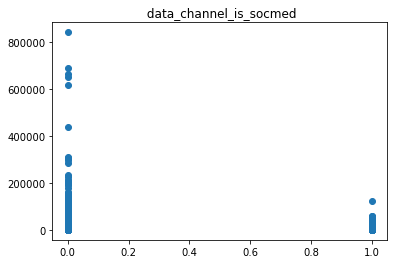

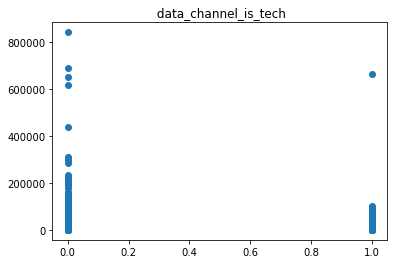

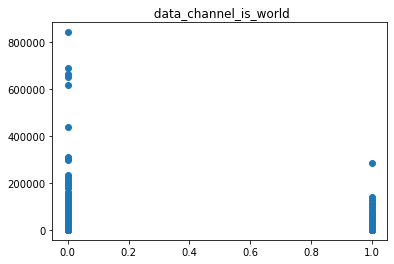

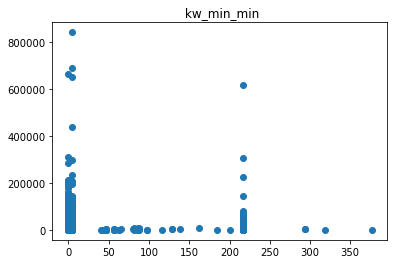

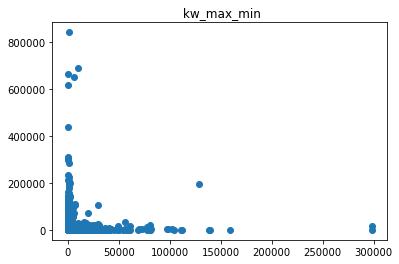

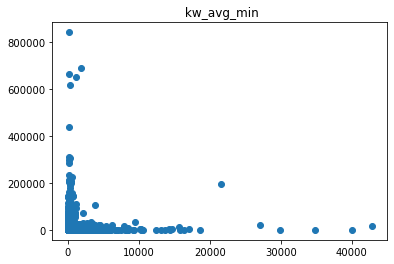

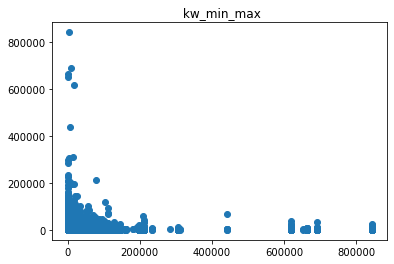

In [52]:
for col in df.columns[13:21]:
    fig, ax = plt.subplots()
    ax.scatter(df[col], df[' shares'])
    ax.set_title(f"{col}")

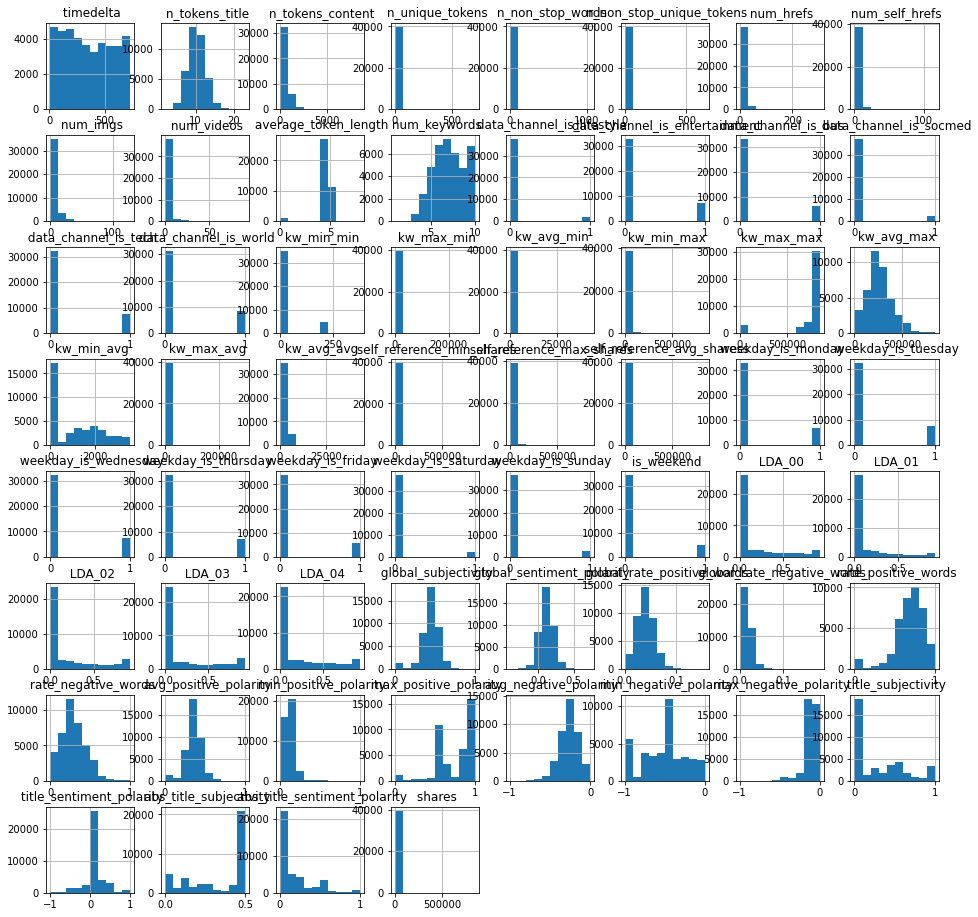

In [44]:
df.hist(figsize=(16, 16))
fig.tight_layout();

(0.0, 80000.0)

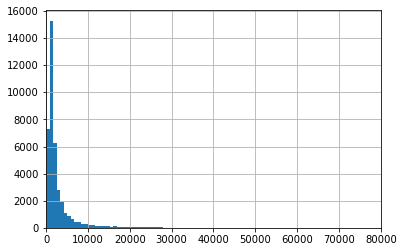

In [113]:
fig, ax = plt.subplots()
df[' shares'].hist(ax = ax, bins = 1000)
ax.set_xlim(0, 80000)

In [137]:
baseline = np.array([1] * len(df[' shares'])) * df[' shares'].mean()
rmse_base = (mean_squared_error(baseline, df[' shares']))**.5
base_residuals = abs(baseline - df[' shares'])
np.mean(base_residuals)

3205.399026154762

In [ ]:
fig, ax = plt.subplots(figsize = (12, 8))
ax.scatter(df.index, np.log(df[' shares']), alpha = .3, c = 'g', label = 'shares')
ax.axhline(np.log(df[' shares'].mean()), label = 'average number of shares', c = 'y')
ax.set_ylabel('log(number of shares)')
ax.set_title('Baseline Model (Mean)')
ax.set_xlabel('article (dataframe row)')
ax.scatter(df.index, np.log(abs(baseline - df[' shares'])), c = 'r', alpha = .1, label = 'residuals')
ax.axhline(np.log(np.mean(base_residuals)), label = 'average residual', c = 'black')
ax.legend()
plt.savefig('../img/Baseline-Model.png');

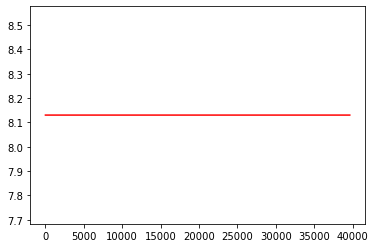

In [91]:
fig, ax = plt.subplots()
ax.plot(df.index, np.log(baseline), c = 'r')